### Quality (Profitability) + Value Factor

[**Profitability**] <br>
GPOA = 매출총이익 / 총자산 <br>
CFOA = 영업활동현금흐름 / 총자산 <br>
GMAR = 매출총이익 / 매출액 <br>
ROE = 순이익 / 자본 <br>
ROA = 순이익 / 자산 <br> 

[**Value**] <br>
PER (Price Earnings Ratio): 시가총액 / 당기순이익 <br>
PBR (Price Book value Ratio): 시가총액 / 자본 <br>
PSR (Price Sales revenue Ratio): 시가총액 / 매출액 <br>
PCR (Price Cash flow Ratio): 시가총액 / 영업활동현금흐름 <br>
EPS (Earning Price Ratio): 당기순이익 / 발행주식수 <br>

[**Momentum**] <br>
3M: 3개월 모멘텀 <br>
6M: 6개월 모멘텀 <br>
9M: 9개월 모멘텀 <br>
12M: 12개월 모멘텀 <br>

In [2]:
cd ..

/home/hyunjun/workspace/FactorSearch (mom)


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import random
from scipy.stats import zscore

np.set_printoptions(suppress=True)

In [98]:
class FactorManager:

    """
    투자 유니버스가 되는 종목들의 
    Momentum Factor 데이터를 관리한다.

    1M, 3M, 6M, 9M, 12M

    M12_1, M12_3, M12_6, M12_9

    Kratio
    """

    path1 = 'data4/factors_kr.csv'
    path2 = 'data4/price_kr.csv'
    path3 = 'data4/kospi.csv'

    def __init__(self, factors):    
        """
        all: 전 종목의 모든 팩터의 값을 담고 있는 데이터프레임
        price: 전 종목의 종가 값을 담고 있는 데이터프레임
        kospi: 코스피 지수 종가 값을 담고 있는 데이터프레임
        

        [Ex: all]
        종목코드  기준일       팩터   값
        000990  2016-03-31  1M  0.04707
        000990  2016-03-31  3M   0.0786
        ...     ...         ...     ...
        035000  2023-06-31  6M   0.008364
        """    
        self.all = pd.read_csv(self.path1, index_col=0, dtype={'종목코드':str})
        self.kospi = pd.read_csv(self.path3, index_col=0)
        self.price = pd.read_csv(self.path2, index_col=0)
        self.factors = factors

    def get_FactorData(self, name:str) -> pd.DataFrame:
        """
        하나의 팩터 이름을 받아, 
        해당 팩터의 전 종목에 대한 값 데이터를 리턴

        
        [Ex: self.get_FactorData('PER')]
        종목코드      000990  001040  001230   001250  ... 
        기준일
        
        2016-03-31  0.03984 0.06998  0.03678  0.03482 ...   
        2016-06-30  0.03820 0.09536  0.09001  0.09153 ...
        ...
        2022-06-30 
        """

        factor_data = self.all[self.all['팩터'] == name][['종목코드', '날짜', '값']]
        factor_data = factor_data.pivot(index='날짜', columns='종목코드', values='값')
        return factor_data
    
    def get_ScoreEACH(self, date:str) -> pd.DataFrame:
        """
        특정 Date에서 각 종목들의 팩터별 스코어 데이터 리턴 (MinMax)

        
        [Ex: self.get_ScoreEACH('2022-12-31')]
        팩터       1M   3M   6M   ...   Kratio
        종목코드
        000990    1.0    9.0   41.0   ...   45.0
        001040    13.0   5.0   13.0   ...   1.0 
        ...
        001520    8.0    16.0  20.0   ...   13.0
        """
        values = self.all[self.all['날짜'] == date][['종목코드', '팩터', '값']]
        values = values.pivot(index='종목코드', columns='팩터', values='값')
        self.set_w()
        
        is_ascending = {
            '1M': True, '3M': True, 
            '6M': True,  '9M': True,
            '12M': True, '12_1M': True, 
            '12_3M': True, '12_6M': True,
            '12_9M': True, 'Kratio': True,
            'rand1': True, 'rand2': True, 
            'rand3': True, 'rand4': True, 
            }  
        
        factor_score = values[self.factors]
        factor_score = factor_score.apply(self.rankin_func)
        factor_score = factor_score.apply(self.minmax_func)
        factor_score = factor_score.apply(self.weight_func)
        return factor_score
    
    def get_RankALL(self):
        """
        각 팩터 스코어를 합하여 토탈 랭킹 데이터 리턴

        [Ex: self.get_ScoreSUM()]
        종목코드    000990  001040  001230   001250  ... 
        기준일
        
        2016-03-31  9.0     7.0     17.0    2.0 ...   
        2016-06-30  9.0     6.0     1.0     51.0 ...
        ...
        2022-06-30 
        """
        dates = self.price.index
        rank_all = [self.get_ScoreEACH(date)[self.factors].\
                    sum(axis=1).rank(method='first', ascending=False) for date in dates]
        rank_all = pd.concat(rank_all, axis=1).transpose()
        rank_all.index = dates
        return rank_all
    
    def set_w(self, value=None):
        """
        각 팩터의 가중치를 결정하는 함수
        """

        default_weight = dict(zip(self.factors, np.ones(len(self.factors))))
        self.weight_dict = default_weight if value is None else \
            dict(zip(self.factors, value))
        
    def rankin_func(self, series):
        return series.rank(method='first')
    
    def weight_func(self, series):
        return series*self.weight_dict[series.name]
    
    def minmax_func(self, series):
        return (series-min(series)) / (max(series)-min(series)) + 1

In [99]:
factors = ['1M', '3M', '6M', '9M', '12M', 
           '12_1M', '12_3M', '12_6M', '12_9M', 'Kratio']

In [100]:
FM = FactorManager(factors)

Ex) get_FactorData()

In [ ]:
FM.get_FactorData('Kratio').head()

Ex) get_Ranking()

In [ ]:
FM.get_ScoreEACH('2022-03-31').head()

Ex) get_RankingSUM()

In [ ]:
FM.get_RankALL().head()

Multi Factor (Quality + Value) Portfolio, Rebalancing-3M

In [125]:
""" 
멀티 팩터 토탈 랭킹 (동일 가중 합 랭킹) 데이터로 변환
"""
universe = FM.price.copy()['2015':'2023']
rank_all = FM.get_RankALL()['2015':'2023']

In [126]:
def get_action(index: int, top_n: int, q: int=1):
    tickers = universe.columns.to_numpy()
    ticker = tickers[(rank_all.iloc[index].to_numpy() <= top_n * q) &
                     (rank_all.iloc[index].to_numpy() > top_n * (q-1))]
    
    weight = np.ones(top_n) / top_n
    return ticker, weight

In [129]:
"""
Backtesting Loop
"""

from object import Portfolio
from object import Order
from datetime import datetime
st = datetime.strptime

q = 1
n = 30
cum_profitloss = 0
balance = 0
init_balance = 1000
portfolio_value = init_balance
quarter = '1Q'
freq = {'1Q': range(1,13), '2Q': [6, 12], '4Q': [12]}

PVs = []
PFs = []
POs = []
TIs = []

for i in range(0, len(universe)):

    ticker_old, weight_old = get_action(i, n, q)
    p_old = Portfolio(ticker_old, weight_old) if i == 0 else p_old
    price_old = universe.iloc[i][p_old.ticker].values if i == 0 else price_old

    POs.append(p_old.weight)
    TIs.append(p_old.ticker)
    PVs.append(portfolio_value)
    PFs.append(cum_profitloss)
    
    # 여기는 get_price 함수로 (인자는 ticker 받도록)
    price_old = universe.iloc[i-1][p_old.ticker].values
    price_now = universe.iloc[i][p_old.ticker].values

    # 다음 타임 스텝에서 가격 변동으로 인한 포트폴리오 변화
    ratio = (price_now - price_old) / price_old
    ratio = np.where(np.isnan(ratio), np.float64(-0.99), ratio)

    profitloss = np.dot(ratio, p_old.weight)
    portfolio_value *= (1 + profitloss)
    cum_profitloss = ((portfolio_value / init_balance -1) * 100)

    weight_now = p_old.weight * (1+ratio) 
    weight_now = weight_now / np.sum(weight_now)

    p_old.update_weight(weight_now)
    
    # Desired Portfolio
    check = st(rank_all.index[i], '%Y-%m-%d').month in freq[quarter]
    ticker, weight = get_action(i, n, q) if check else (p_old.ticker, p_old.weight)
    p_new = Portfolio(ticker, weight)

    """
    Order 계산
    """
    # Gap 계산 대상
    gap_ticker = p_old.ticker[np.isin(p_old.ticker, p_new.ticker)] 

    # Gap 사이즈
    gap_size = p_new.weight[np.isin(p_old.ticker, p_new.ticker)] - \
        p_old.weight[np.isin(p_old.ticker, p_new.ticker)]
    
    # 매도 대상
    sell_ticker = p_old.ticker[~ np.isin(p_old.ticker, p_new.ticker)]

    # 매도 대상 사이즈
    sell_size = -p_old.weight[~ np.isin(p_old.ticker, p_new.ticker)]

    # 매수 대상
    buy_ticker = p_new.ticker[~ np.isin(p_new.ticker, p_old.ticker)]

    # 매수 대상 사이즈
    buy_size = p_new.weight[~ np.isin(p_new.ticker, p_old.ticker)]

    # 오더
    order = Order()

    gap_order = (gap_ticker, gap_size)
    sell_order = (sell_ticker, sell_size)
    buy_order = (buy_ticker, buy_size)

    order.append(*gap_order)
    order.append(*sell_order)
    order.append(*buy_order)
        
    # 보유하고 있는 종목과 보유할 종목을 combine 해놓기
    combine = {}.fromkeys(order.ticker, 0.0)
    combine.update(p_old.dict)
    weight = np.fromiter(combine.values(), dtype=np.float64)
    
    """
    거래 
    """
    CHARGE = 0.000 #0.001
    TEX = 0.0000 #0.0025
    FEE = 0.0

    sell_cost = CHARGE + TEX
    buy_cost = CHARGE

    action = order.size

    # 매도 주문부터
    sell_ind = np.where( (action < 0) )[0]
    weight[sell_ind] += action[sell_ind]
    sell_moneys = portfolio_value * abs(action[sell_ind]) * (1.0-sell_cost)
    sell_amount = np.sum(sell_moneys) 
    balance += sell_amount
    FEE += sell_amount * sell_cost

    # 매수 주문 처리
    buy_ind = np.where( (action > 0) )[0]
    buy_moneys = portfolio_value * action[buy_ind] * (1.0+buy_cost)
    buy_amount = np.sum(buy_moneys) 

    allocation = buy_moneys / buy_amount

    buy_fee = balance * (buy_cost/(1+buy_cost)) 
    feasible_buy_moneys = (balance - buy_fee) * allocation 
    feasible_buy_amount = np.sum(feasible_buy_moneys)
    feasible_buy_action = feasible_buy_moneys / portfolio_value
    FEE += feasible_buy_amount * buy_cost # (= buy_fee)

    weight[buy_ind] += feasible_buy_action
    weight = weight / np.sum(weight)

    portfolio_value -= FEE
    balance -= feasible_buy_amount 

    p_old = Portfolio(order.ticker[weight>0], weight[weight>0])

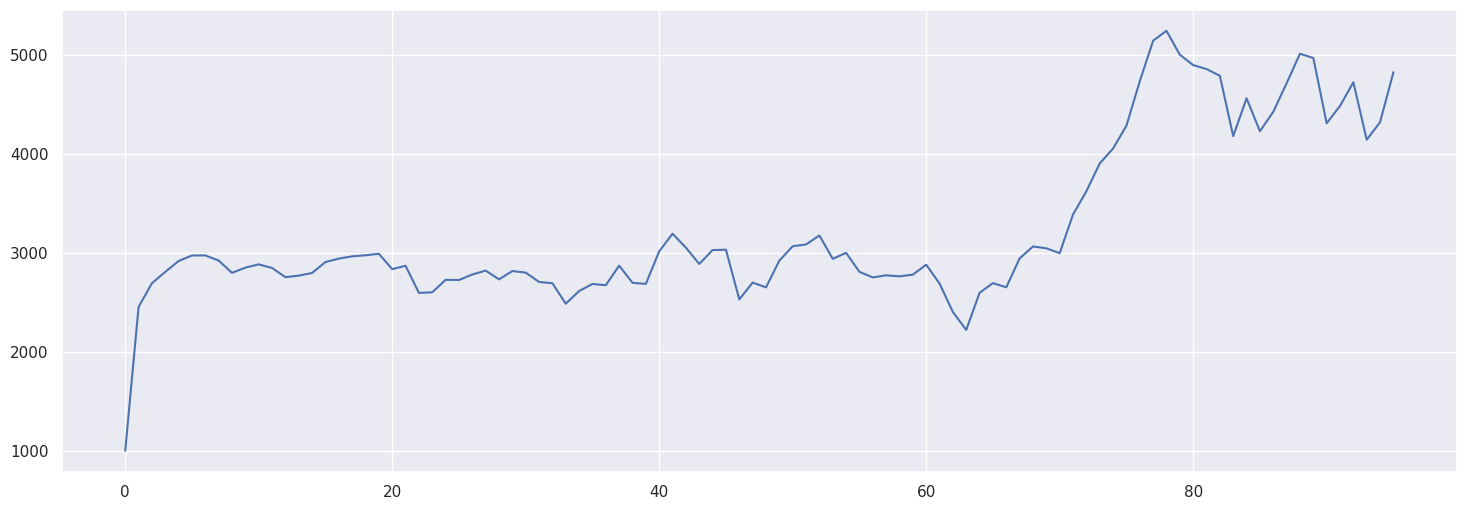

In [130]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(PVs)

In [ ]:
free = 0.04 / 12

R_i = (np.array(PVs)[1:] / np.array(PVs)[:-1]) - 1
kospi = FM.kospi['2016':'2024'].values
R_f = (kospi[1:] / kospi[:-1]) - 1
coefficients = np.polyfit(R_i-free, R_f-free, 1)
coefficients[-1]

Sharpe ratio, MDD, alpha (CAPM), RankIC

In [29]:
def get_mdd(pvs):
    df = pd.DataFrame(pvs)
    premaxs = df.cummax()
    drawdowns = (1-df / premaxs) * 100
    mdd = drawdowns.max().iloc[0]
    return mdd

def get_sharpe(pvs):
    pvs = np.array(pvs)
    pct = (pvs[1:] - pvs[:-1]) / pvs[:-1]
    free = (0.03) / 12
    ratio = np.mean(pct - free) / np.std(pct)
    return ratio

def get_RankIC(q):
    rank = FM.get_RankALL()
    rate = FM.price.pct_change().iloc[1:].rank(ascending=False)
    rank = rank[(rank <= n*q) & (rank > n*(q-1))]
    coeffs = []
    
    for i in range(len(rate)):
        data1 = rank.iloc[i].dropna()
        data2 = rate.iloc[i][data1.index.to_numpy()]
        coeff = np.corrcoef(data1, data2)
        coeffs.append(coeff)

    RankIC = np.mean(coeffs)
    return RankIC

In [36]:
print(f'MDD: {get_mdd(PVs)} \n')
print(f'SR: {get_sharpe(PVs[::12])} \n')
print(f'RankIC: {get_RankIC(q=1)} \n')

MDD: 54.04331567861542 

SR: 0.43379484367823606 

RankIC: 0.48769488198179073 

